In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(stringr))
library(plyr)
library(purrr)
library(rstatix)
library(ggpubr)
library(ggsci)
library(ggrepel)
source('../helper_function/helper_function_IHA.r')

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘patchwork’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘plyr’ was built under R version 4.3.3”
------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Warning message:
“package ‘purrr’ was built under R version 4.3.3”

Attaching pa

In [2]:

is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  } else {return('black')}
}

In [3]:
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_annotation$label<-gsub(' cell','',color_annotation$label)
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [4]:
freq=read.csv('01_Frequency_Comparison/freq_actual_flu_year_1_D0_D7.csv')

In [5]:
celltype_order <- unique(freq$AIFI_L3)
celltype_order<-gsub(' cell','',celltype_order)
freq$AIFI_L3<-gsub(' cell','',freq$AIFI_L3)
freq$AIFI_L3 <- factor(freq$AIFI_L3,levels=celltype_order)

In [6]:
freq <- freq %>% dplyr::mutate(`Age Group` = case_when(
  cohort.cohortGuid == "BR1" ~ "Young",
  cohort.cohortGuid == "BR2" ~ "Older",
  TRUE ~ NA_character_
))
freq$`Age Group`<-factor(freq$`Age Group`,levels=c("Young","Older"))

In [7]:
freq$Group<-paste0(freq$`Age Group`,'_',freq$Flu_Day)

In [8]:
freq$Group<-factor(freq$Group,levels=c('Young_Day 0','Young_Day 7',
                                       'Older_Day 0','Older_Day 7'))

In [9]:
# we need to filter out subject if he/she does not has the matched samples on day 0 and day 7
freq <- freq %>% filter( !(subject.subjectGuid == 'BR1023' & AIFI_L3 == 'Plasma'))

In [10]:
freq$AIFI_L3<-factor(freq$AIFI_L3,levels=c('Plasma','CD27+ effector B','CD27- effector B',
                                           'Core memory B','CD95 memory B',
                                           'Type 2 polarized memory B'))

In [11]:
write.csv(freq %>% select(subject.subjectGuid,`Age Group`,Flu_Day,Group,AIFI_L3,AIFI_L3_clr),
          "/home//workspace/Source_Data/Extended_Fig6a.csv", 
          row.names=FALSE)

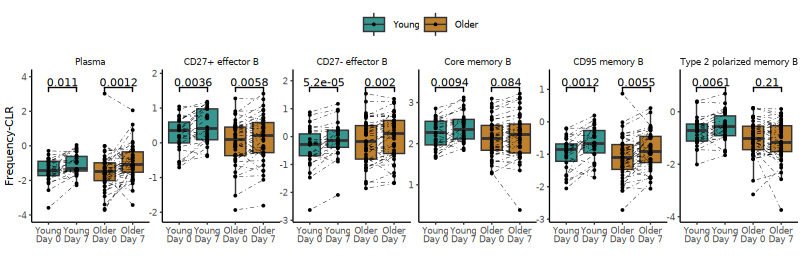

In [16]:
options(repr.plot.width = 170/25.4, repr.plot.height = 55/25.4)


p<-ggplot(freq %>% arrange(subject.subjectGuid,Flu_Day), aes(x=Group, y=AIFI_L3_clr, fill=`Age Group`)) +
   geom_boxplot(outlier.shape = NA,lwd=0.3) +
geom_point(color="black", size=0.8,stroke=0) +
theme_classic(base_size=6)+  
stat_compare_means( label = "p.format",method='wilcox.test',paired=TRUE,size=2.2,
  comparisons = list(c("Older_Day 0", "Older_Day 7")))+  
stat_compare_means( label = "p.format",method='wilcox.test',paired=TRUE,size=2.2,
  comparisons = list(c("Young_Day 0", "Young_Day 7")))+
    scale_fill_manual(values = c("Older" = '#bf812d', "Young" = '#35978f'))+
    scale_y_continuous(limits = c(NA, NA),
                       expand = expansion(mult = c(0.1, 0.15)))+
theme(legend.position="none")+
xlab('')+
ylab('Frequency-CLR')+
facet_wrap(~AIFI_L3,  ncol=6, scale='free_y') +theme(
panel.border = element_blank())   + 
scale_x_discrete(labels = c("Older_Day 0" = "Older\nDay 0", 
                              "Older_Day 7" = "Older\nDay 7",
                              "Young_Day 0" = "Young\nDay 0",
                              "Young_Day 7" = "Young\nDay 7")) +
    theme(axis.line = element_line(colour = "black"),
          legend.position = "top",
          legend.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          strip.background = element_rect(linewidth = 0),
          axis.title.x = element_text(margin = margin(t = 1)))+geom_line(aes(group = interaction(`Age Group`, subject.subjectGuid)), 
              color = "black", 
              linewidth=0.1, 
              linetype =4) + theme(
    panel.spacing = unit(-0.05,'lines')
  )
p




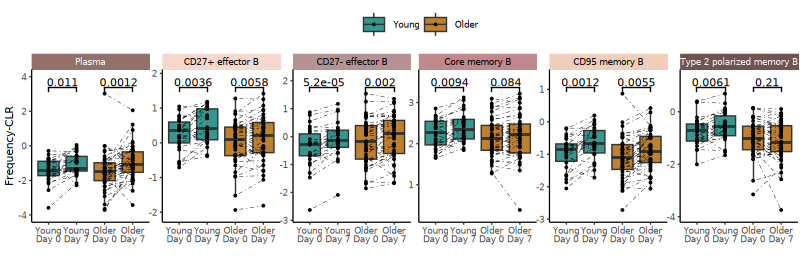

In [17]:
plot <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl('strip-', plot$layout$name))
strip_labels <- sapply(strips, function(i) {
  plot$grobs[[i]]$grobs[[1]]$children[[2]]$children[[1]]$label
})
strip_labels<-gsub(' cell','',strip_labels)

pal <- color_vector[strip_labels]
text_color <- sapply(color_vector[strip_labels], is_dark_color)

strip_names <- plot$layout$name[strips]


for (i in seq_along(strips)) {
  strip_name <- strip_names[i]

  
  k <- which(grepl('rect', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl('titleGrob', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  
  adjusted_color <- adjustcolor(pal[i], alpha.f = 0.8)
  
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <- adjusted_color
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}

plot(plot)
ggsave('FigureF.pdf',
       plot,
       width = 170/25.4,
       height = 55/25.4)